<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 11751, '日付': '2022-01-31T08:00:00.000Z'},
 {'小計': 14445, '日付': '2022-02-01T08:00:00.000Z'},
 {'小計': 21576, '日付': '2022-02-02T08:00:00.000Z'},
 {'小計': 20679, '日付': '2022-02-03T08:00:00.000Z'},
 {'小計': 19798, '日付': '2022-02-04T08:00:00.000Z'},
 {'小計': 21122, '日付': '2022-02-05T08:00:00.000Z'},
 {'小計': 17526, '日付': '2022-02-06T08:00:00.000Z'},
 {'小計': 12211, '日付': '2022-02-07T08:00:00.000Z'},
 {'小計': 17113, '日付': '2022-02-08T08:00:00.000Z'},
 {'小計': 18287, '日付': '2022-02-09T08:00:00.000Z'},
 {'小計': 18891, '日付': '2022-02-10T08:00:00.000Z'},
 {'小計': 18660, '日付': '2022-02-11T08:00:00.000Z'},
 {'小計': 11765, '日付': '2022-02-12T08:00:00.000Z'},
 {'小計': 13074, '日付': '2022-02-13T08:00:00.000Z'},
 {'小計': 10334, '日付': '2022-02-14T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-02-10 17:00:00+09:00,1537,0,18891,2022-02-10 17:00:00+09:00
2022-02-11 17:00:00+09:00,1757,0,18660,2022-02-11 17:00:00+09:00
2022-02-12 17:00:00+09:00,1785,0,11765,2022-02-12 17:00:00+09:00
2022-02-13 17:00:00+09:00,1385,0,13074,2022-02-13 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-02-10 17:00:00+09:00,1537,0,18891,2022-02-10 17:00:00+09:00,1949.571429,13647.0,0.0,0.0,17849.714286,124948.0
2022-02-11 17:00:00+09:00,1757,0,18660,2022-02-11 17:00:00+09:00,1883.571429,13185.0,0.0,0.0,17687.142857,123810.0
2022-02-12 17:00:00+09:00,1785,0,11765,2022-02-12 17:00:00+09:00,1817.714286,12724.0,0.0,0.0,16350.428571,114453.0
2022-02-13 17:00:00+09:00,1385,0,13074,2022-02-13 17:00:00+09:00,1742.714286,12199.0,0.0,0.0,15714.428571,110001.0
2022-02-14 17:00:00+09:00,0,0,10334,2022-02-14 17:00:00+09:00,1423.857143,9967.0,0.0,0.0,15446.285714,108124.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-01-31 17:00:00+09:00,3277,0,11751,2022-01-31 17:00:00+09:00,2723.000000,19061.0,0.0,0.0,15163.857143,106147.0,'22w05,Mon
2022-02-01 17:00:00+09:00,2415,0,14445,2022-02-01 17:00:00+09:00,2696.571429,18876.0,0.0,0.0,15397.000000,107779.0,'22w05,Tue
2022-02-02 17:00:00+09:00,2107,0,21576,2022-02-02 17:00:00+09:00,2638.000000,18466.0,0.0,0.0,16467.000000,115269.0,'22w05,Wed
2022-02-03 17:00:00+09:00,2043,0,20679,2022-02-03 17:00:00+09:00,2584.142857,18089.0,0.0,0.0,17058.571429,119410.0,'22w05,Thu
2022-02-04 17:00:00+09:00,2219,0,19798,2022-02-04 17:00:00+09:00,2531.714286,17722.0,0.0,0.0,17368.142857,121577.0,'22w05,Fri
2022-02-05 17:00:00+09:00,2246,0,21122,2022-02-05 17:00:00+09:00,2394.142857,16759.0,0.0,0.0,17895.142857,125266.0,'22w05,Sat
2022-02-06 17:00:00+09:00,1910,0,17526,2022-02-06 17:00:00+09:00,2316.714286,16217.0,0.0,0.0,18128.142857,126897.0,'22w05,Sun
2022-02-07 17:00:00+09:00,2232,0,12211,2022-02-07 17:00:00+09:00,2167.428571,15172.0,0.0,0.0,18193.857143,127357.0,'22w06,Mon
2022-02-08 17:00:00+09:00,1867,0,17113,2022-02-08 17:00:00+09:00,2089.142857,14624.0,0.0,0.0,18575.000000,130025.0,'22w06,Tue
2022-02-09 17:00:00+09:00,1636,0,18287,2022-02-09 17:00:00+09:00,2021.857143,14153.0,0.0,0.0,18105.142857,126736.0,'22w06,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-01-30 17:00:00+09:00,14699.857143,102899
2022-02-06 17:00:00+09:00,18128.142857,126897
2022-02-13 17:00:00+09:00,15714.428571,110001
2022-02-14 17:00:00+09:00,10334.000000,10334
2022-01-02 17:00:00+09:00,81.500000,163


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-01-31 17:00:00+09:00,3277,0,11751,2022-01-31 17:00:00+09:00,2723.000000,19061.0,0.0,0.0,15163.857143,106147.0,'22w05,Mon,NaN,NaN
2022-02-01 17:00:00+09:00,2415,0,14445,2022-02-01 17:00:00+09:00,2696.571429,18876.0,0.0,0.0,15397.000000,107779.0,'22w05,Tue,NaN,NaN
2022-02-02 17:00:00+09:00,2107,0,21576,2022-02-02 17:00:00+09:00,2638.000000,18466.0,0.0,0.0,16467.000000,115269.0,'22w05,Wed,NaN,NaN
2022-02-03 17:00:00+09:00,2043,0,20679,2022-02-03 17:00:00+09:00,2584.142857,18089.0,0.0,0.0,17058.571429,119410.0,'22w05,Thu,NaN,NaN
2022-02-04 17:00:00+09:00,2219,0,19798,2022-02-04 17:00:00+09:00,2531.714286,17722.0,0.0,0.0,17368.142857,121577.0,'22w05,Fri,NaN,NaN
2022-02-05 17:00:00+09:00,2246,0,21122,2022-02-05 17:00:00+09:00,2394.142857,16759.0,0.0,0.0,17895.142857,125266.0,'22w05,Sat,NaN,NaN
2022-02-06 17:00:00+09:00,1910,0,17526,2022-02-06 17:00:00+09:00,2316.714286,16217.0,0.0,0.0,18128.142857,126897.0,'22w05,Sun,18128.142857,126897.0
2022-02-07 17:00:00+09:00,2232,0,12211,2022-02-07 17:00:00+09:00,2167.428571,15172.0,0.0,0.0,18193.857143,127357.0,'22w06,Mon,NaN,NaN
2022-02-08 17:00:00+09:00,1867,0,17113,2022-02-08 17:00:00+09:00,2089.142857,14624.0,0.0,0.0,18575.000000,130025.0,'22w06,Tue,NaN,NaN
2022-02-09 17:00:00+09:00,1636,0,18287,2022-02-09 17:00:00+09:00,2021.857143,14153.0,0.0,0.0,18105.142857,126736.0,'22w06,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

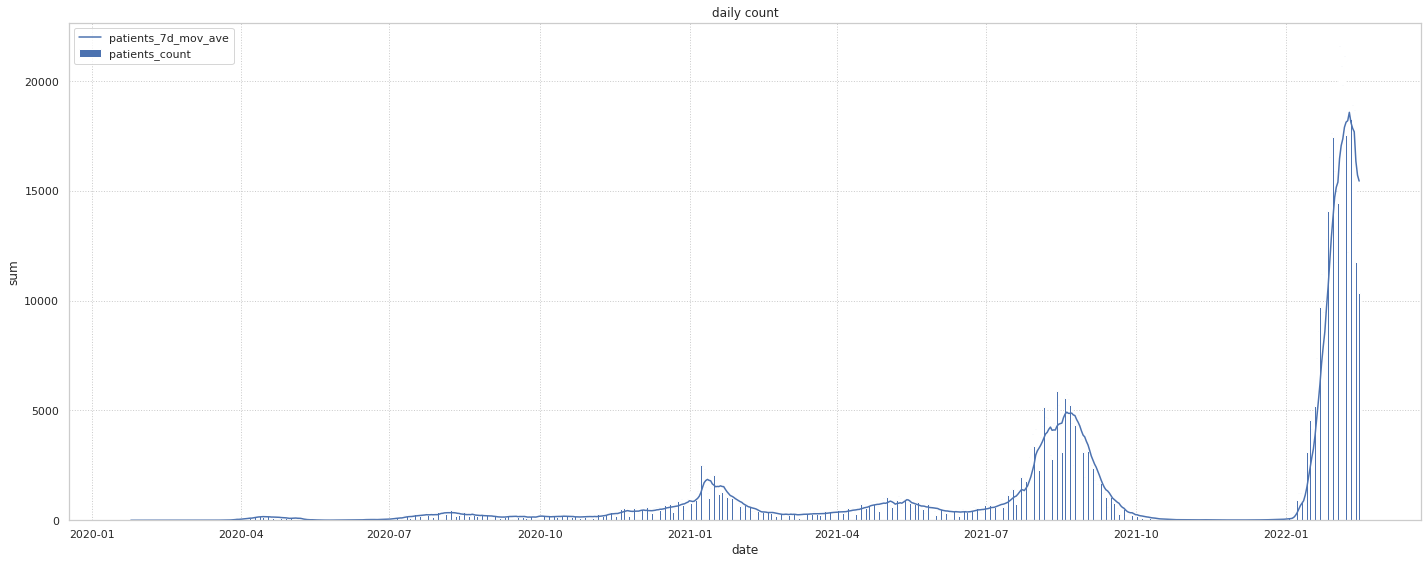

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
738,1.643616e+09,2022,1,31,0,1,0,0,0,0,0,738,0,664,3277,2723.000000,19061.0,0,0.0,0.0,11751,15163.857143,106147.0
739,1.643702e+09,2022,2,1,0,0,0,0,0,1,0,739,0,665,2415,2696.571429,18876.0,0,0.0,0.0,14445,15397.000000,107779.0
740,1.643789e+09,2022,2,2,0,0,0,0,0,0,1,740,0,666,2107,2638.000000,18466.0,0,0.0,0.0,21576,16467.000000,115269.0
741,1.643875e+09,2022,2,3,0,0,0,0,1,0,0,741,0,667,2043,2584.142857,18089.0,0,0.0,0.0,20679,17058.571429,119410.0
742,1.643962e+09,2022,2,4,1,0,0,0,0,0,0,742,0,668,2219,2531.714286,17722.0,0,0.0,0.0,19798,17368.142857,121577.0
743,1.644048e+09,2022,2,5,0,0,1,0,0,0,0,743,0,669,2246,2394.142857,16759.0,0,0.0,0.0,21122,17895.142857,125266.0
744,1.644134e+09,2022,2,6,0,0,0,1,0,0,0,744,0,670,1910,2316.714286,16217.0,0,0.0,0.0,17526,18128.142857,126897.0
745,1.644221e+09,2022,2,7,0,1,0,0,0,0,0,745,0,671,2232,2167.428571,15172.0,0,0.0,0.0,12211,18193.857143,127357.0
746,1.644307e+09,2022,2,8,0,0,0,0,0,1,0,746,0,672,1867,2089.142857,14624.0,0,0.0,0.0,17113,18575.000000,130025.0
747,1.644394e+09,2022,2,9,0,0,0,0,0,0,1,747,0,673,1636,2021.857143,14153.0,0,0.0,0.0,18287,18105.142857,126736.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            753 non-null    float64
 1   year                 753 non-null    int64  
 2   month                753 non-null    int64  
 3   day                  753 non-null    int64  
 4   Fri                  753 non-null    uint8  
 5   Mon                  753 non-null    uint8  
 6   Sat                  753 non-null    uint8  
 7   Sun                  753 non-null    uint8  
 8   Thu                  753 non-null    uint8  
 9   Tue                  753 non-null    uint8  
 10  Wed                  753 non-null    uint8  
 11  passed               753 non-null    int64  
 12  emergency            753 non-null    int64  
 13  em_passed            753 non-null    int64  
 14  contacts_count       753 non-null    int64  
 15  contacts_7d_mov_ave  753 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.530000e+02,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000
mean,1.612339e+09,2020.604250,6.377158,15.710491,0.143426,0.143426,0.143426,0.143426,0.142098,0.142098,0.142098,376.000000,0.065073,305.685259,678.737052,674.175836,4719.225764,489.401062,489.401062,3425.807437,1080.031873,1025.684178,7179.767596
std,1.879344e+07,0.599275,3.500169,8.856486,0.350740,0.350740,0.350740,0.350740,0.349383,0.349383,0.349383,217.516666,0.246819,211.867332,566.111294,551.487294,3860.417255,789.922055,724.916724,5074.417067,2914.161859,2735.530534,19148.721863
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.596096e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,188.000000,0.000000,114.000000,319.000000,323.714286,2266.000000,0.000000,0.000000,0.000000,48.000000,47.857143,335.000000
50%,1.612339e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,376.000000,0.000000,302.000000,506.000000,503.285714,3523.000000,0.000000,0.000000,0.000000,250.000000,261.714286,1832.000000
75%,1.628582e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,564.000000,0.000000,490.000000,824.000000,818.571429,5730.000000,982.000000,1048.428571,7339.000000,634.000000,649.142857,4544.000000
max,1.644826e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,752.000000,1.000000,678.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21576.000000,18575.000000,130025.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.879827,0.233940,-0.007697,-0.002824,0.002824,-0.000941,0.000941,0.001872,-0.001872,-8.034963e-17,1.000000e+00,-0.337406,0.998505,-0.051540,-0.050318,-0.050315,-0.618350,-0.664475,-0.664475,0.407024,0.404434,0.404435
year,8.798268e-01,1.000000,-0.254606,-0.052183,-0.001638,0.004688,0.004688,0.004688,-0.004158,-0.004158,-4.158206e-03,8.798268e-01,-0.266189,0.885725,0.076402,0.075935,0.075936,-0.625530,-0.681623,-0.681623,0.526727,0.517286,0.517287
month,2.339400e-01,-0.254606,1.000000,0.008675,-0.002960,-0.004044,-0.011626,-0.008376,0.012662,0.005050,9.399630e-03,2.339400e-01,-0.140814,0.218683,-0.263442,-0.258894,-0.258891,0.022880,0.044841,0.044841,-0.250889,-0.235891,-0.235889
day,-7.697363e-03,-0.052183,0.008675,1.000000,0.006964,0.002255,0.000542,0.007820,-0.003448,-0.003877,-1.032378e-02,-7.697363e-03,-0.000495,-0.007230,0.015925,0.001146,0.001144,0.008589,-0.001844,-0.001844,-0.021027,-0.032343,-0.032345
Fri,-2.823705e-03,-0.001638,-0.002960,0.006964,1.000000,-0.167442,-0.167442,-0.167442,-0.166536,-0.166536,-1.665358e-01,-2.823705e-03,-0.000428,-0.002344,-0.013231,-0.001726,-0.001726,0.025182,-0.001097,-0.001097,0.020328,0.000531,0.000530
Mon,2.823705e-03,0.004688,-0.004044,0.002255,-0.167442,1.000000,-0.167442,-0.167442,-0.166536,-0.166536,-1.665358e-01,2.823705e-03,-0.000428,0.002863,0.028238,0.001387,0.001387,0.102544,-0.001097,-0.001097,-0.045707,0.007494,0.007494
Sat,-9.412350e-04,0.004688,-0.011626,0.000542,-0.167442,-0.167442,1.000000,-0.167442,-0.166536,-0.166536,-1.665358e-01,-9.412350e-04,-0.000428,-0.000609,0.044720,0.000027,0.000027,-0.120536,-0.001097,-0.001097,0.016084,0.002860,0.002859
Sun,9.412350e-04,0.004688,-0.008376,0.007820,-0.167442,-0.167442,-0.167442,1.000000,-0.166536,-0.166536,-1.665358e-01,9.412350e-04,-0.000428,0.001127,-0.020243,0.001387,0.001387,-0.111133,-0.001097,-0.001097,-0.007325,0.005448,0.005448
Thu,1.872284e-03,-0.004158,0.012662,-0.003448,-0.166536,-0.166536,-0.166536,-0.166536,1.000000,-0.165635,-1.656347e-01,1.872284e-03,0.000573,0.001395,-0.009277,0.001187,0.001188,0.031676,0.001468,0.001468,0.025252,-0.001750,-0.001750
Tue,-1.872284e-03,-0.004158,0.005050,-0.003877,-0.166536,-0.166536,-0.166536,-0.166536,-0.165635,1.000000,-1.656347e-01,-1.872284e-03,0.000573,-0.002090,-0.017802,-0.001941,-0.001940,0.042821,0.001468,0.001468,-0.018992,-0.009140,-0.009140


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1.644480e+09,0,0,0,0,1,0,0,748,0,674,1537,0,18891,17849.714286,124948.0
749,1.644566e+09,1,0,0,0,0,0,0,749,0,675,1757,0,18660,17687.142857,123810.0
750,1.644653e+09,0,0,1,0,0,0,0,750,0,676,1785,0,11765,16350.428571,114453.0
751,1.644739e+09,0,0,0,1,0,0,0,751,0,677,1385,0,13074,15714.428571,110001.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
748,1.644480e+09,748,0,18891,17849.714286,124948.0
749,1.644566e+09,749,0,18660,17687.142857,123810.0
750,1.644653e+09,750,0,11765,16350.428571,114453.0
751,1.644739e+09,751,0,13074,15714.428571,110001.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

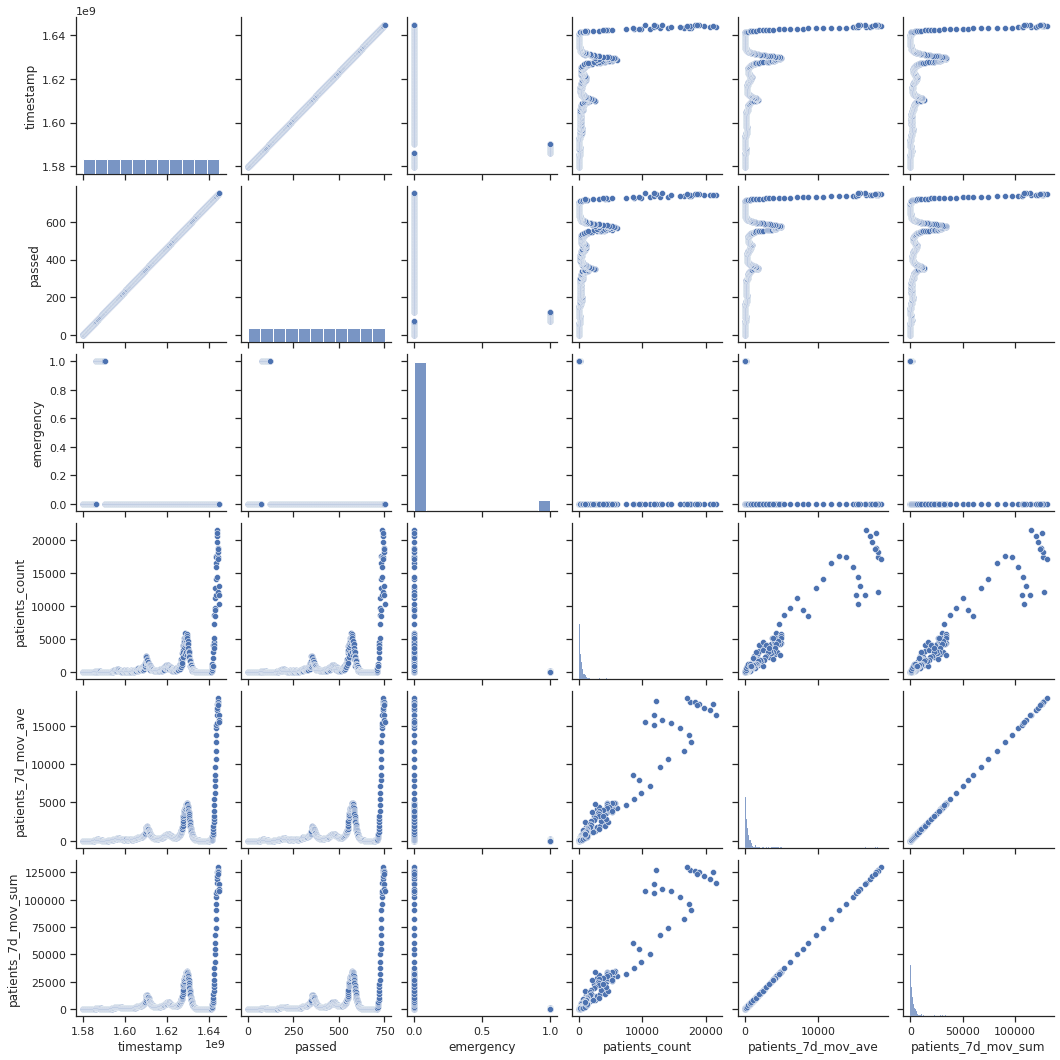

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.27
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==